# Example 04 - Modulations Dataset
This notebook steps through an example of how to use `torchsig` to instantiate a `SignalDataset` containing specific modulations. The notebook then plots the signals using `Visualizers` for both the IQ and Spectrogram representations of the dataset. The end of the notebook then shows how the instantiated dataset can be saved to an LMDB static dataset for standalone research, experimentation, and/or analysis.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [13]:
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer
from torchsig.datasets.modulations import ModulationsDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import pytorch_lightning as pl
import torch
import os

----
### Instantiate Modulations Dataset
Instantiate the `ModulationsDataset` by passing in the desired classes, a boolean specifying whether to use the class name or index as the label, the desired level of signal impairments/augmentations, the number of IQ samples per example, and the total number of samples. Note that the total number of samples will be divided evenly among the class list (for example, `num_samples=5300` will result in 100x samples of each of the 53 modulation classes). Also note that the classes input parameter can be omitted if all classes are desired. 

If all classes are included at `level=0` (clean signals), all signals will occupy roughly half of the returned signal bandwidth except for the FSK and MSK modulations. These two subfamilies do not contain any pulse shaping, and as such are returned at roughly 1/8th occupied bandwidth for the main lobe. At the higher impairment levels, there is a randomized low pass filter applied at the 8x oversampled rate to suppress the sidelobes prior to downsampling to roughly the same half bandwidth target as the remaining signals.

Within the OFDM family, there are 12 subclasses pertaining to the number of subcarriers present within the OFDM signal. These subcarriers are the powers of 2 from 64 to 2048 as well as the LTE specifications values of 72, 180, 300, 600, 900, and 1200. The DC subcarrier is randomly on or off throughout all subcarrier counts. The subcarrier modulations are divided into two categories: 1) randomly select a single modulation from the list: `bpsk, qpsk, 16qam, 64qam, 256qam, and 1024qam` and modulate all subcarriers with the random selection; and 2) randomly select a modulation from the same list for each subcarrier independently. The subcarrier modulations are not included in any of the labels for future classification tasks. In addition to these randomizations, the cyclic prefix ratio is also randomly selected between discrete values of 1/8 and 1/4, and it is also not included in the labels at this time. As a final randomization with the OFDM signals, two distinct sidelobe suppression techniques are evenly sampled from to smooth the discontinuities at the symbol boundaries: 1) apply a window, and 2) apply a low pass filter.

In [7]:
# Seed the dataset instantiation for reproduceability
pl.seed_everything(1234567891)

dataset = ModulationsDataset(
    classes=["bpsk", "qpsk"],
    use_class_idx=True,
    level=0,
    num_iq_samples=4096,
    num_samples=2 * 100,
    include_snr=False,
)

data, modulation = dataset[50]

print("Dataset length: {}".format(len(dataset)))
print("Number of classes: {}".format(2))
print("Data shape: {}".format(data.shape))
print("Example modulation: {}".format(modulation))

Global seed set to 1234567891


Dataset length: 200
Number of classes: 2
Data shape: (4096,)
Example modulation: 0


----
### Plot Subset to Verify
The `IQVisualizer` and the `SpectrogramVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `torchsig` `Visualizer` as shown below.

In [20]:
def index_to_class_name(batch: torch.Tensor) -> str:
    labels = []
    for label in batch:
        if label == 1:
            labels.append("qpsk")
        else:
            labels.append("bpsk")
    return labels

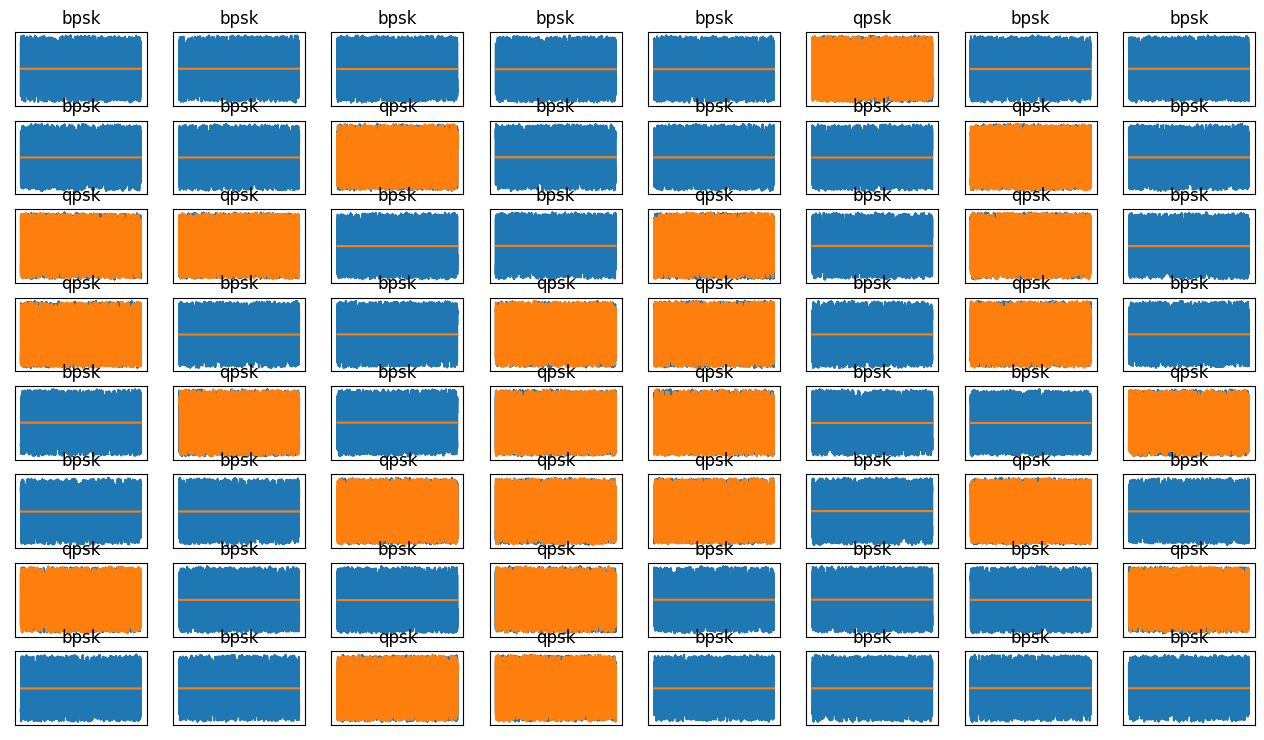

In [21]:
data_loader = DataLoader(dataset=dataset, batch_size=os.cpu_count() // 2, shuffle=True)

visualizer = IQVisualizer(
    data_loader=data_loader,
    visualize_transform=None,
    visualize_target_transform=index_to_class_name
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 9)
    plt.show()
    break

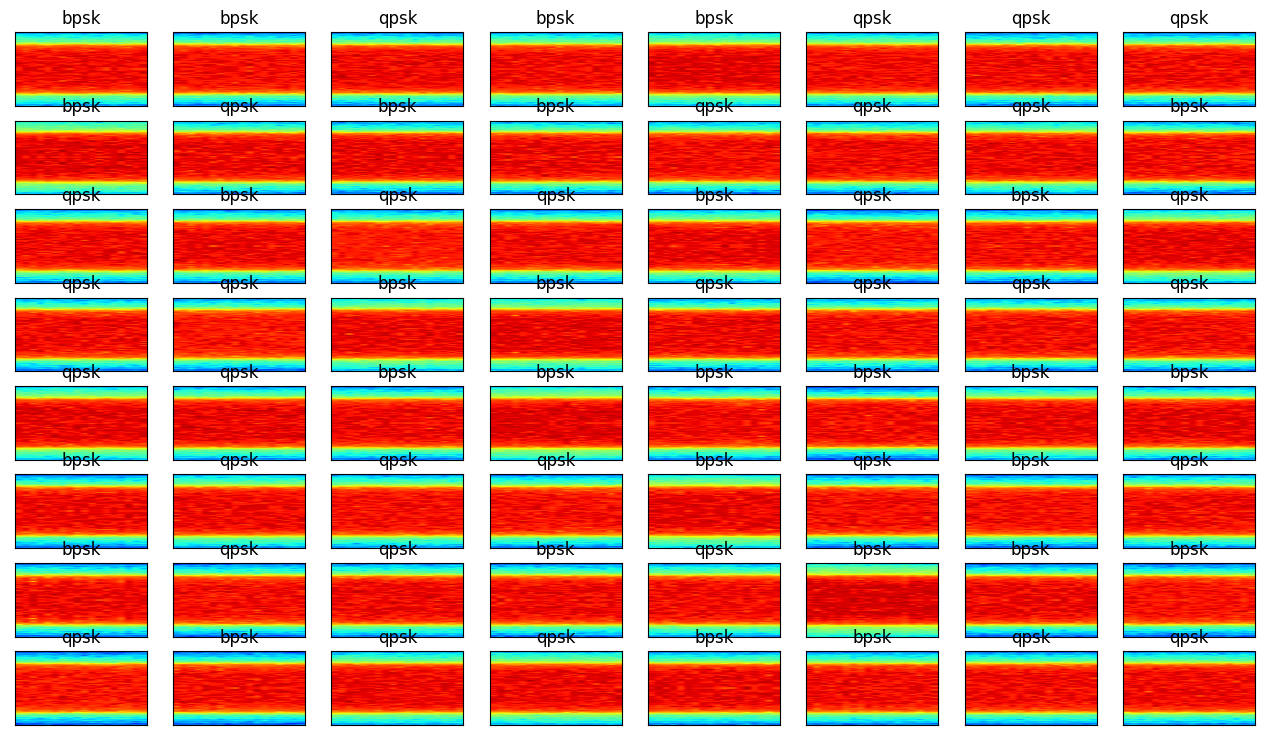

In [22]:
visualizer = SpectrogramVisualizer(
    data_loader=data_loader,
    nfft=1024,
    visualize_transform=None,
    visualize_target_transform=index_to_class_name
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 9)
    plt.show()
    break